<h2>EDA code</h2>

* Group name: Bloodhounds
* Batch code: LISUM09
* Specialization: Data science
* Group member details:
* Margarita Prokhorovich, marusya15071240@gmail.com, Thailand

First things first, we need to read a file and create a dataframe, as usual.

In [2]:
#reading the dataframe
import pandas as pd
df = pd.read_csv('bank-additional-full.csv', delimiter = ';')
print(df.shape)
df.head()

(41188, 21)


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


Let's look at the dataframe info one more time. 

In [83]:
#display the info about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

As we remember, all the data types in the dataframe are correct. However, there are some other issues in the data that we need to eliminate. We will use data cleansing and transformation approaches from the previous project part: will drop the duplicates, transform pdays category, fill unknown values using KNN approach (the fourth one). As for outliers, we prefer to keep them on this stage because removing the outliers can prevent us from identifying patterns in the data more clearly. 

We decided to create pdays_categ feature with labels 'yes' and 'no' because it's easier to process this feature with other categorical features.

In [3]:
#find duplicates and display their quantity
n_duplicates = df.duplicated().sum()
print(f"Number of duplicates - {n_duplicates}.")

#delete all the full duplicates. We can see decreasing in a rows number
df = df.drop_duplicates()
df.shape

Number of duplicates - 12.


(41176, 21)

In [4]:
print(f'\nNumber of examples where a client was not previously contacted - {len(df[df.pdays == 999])}, percentage - {round(len(df[df.pdays == 999])/len(df) * 100,2)}%.')
df['pdays_categ'] = ['no' if pday == 999 else 'yes' for pday in df.pdays]
df = df.drop(['pdays'], axis = 1)


Number of examples where a client was not previously contacted - 39661, percentage - 96.32%.


In [5]:
#create an empty df where new filled columns will be stored
df_final_knn = pd.DataFrame()

#define a function that predicts unknown values
def fill_unknown_knn(column_name):   
   try: 
      #import necessary modules
      from sklearn.model_selection import train_test_split
      from sklearn.utils.class_weight import compute_class_weight
      from sklearn import preprocessing
      from sklearn.preprocessing import LabelEncoder
      from sklearn.neighbors import KNeighborsClassifier      
      from IPython.display import display
      import numpy as np

      #copy df
      df_copy = df.copy()

      #exclude binary features from categories
      global categories 
      categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
      categories = [i for i in categories if i not in [column_name, 'y', 'contact']]

      #transform another categorical features to dummy variables
      deleted_columns = []
      for i in categories:
         dummies_x = pd.get_dummies(df[i])
         deleted_columns.append(dummies_x.columns[0])
         df_copy = pd.concat([df_copy,dummies_x],axis='columns')

      #use label encoder
      le = LabelEncoder()
      #transform binary features - contact and y
      df_copy.contact = le.fit_transform(df_copy.contact)
      df_copy.y = le.fit_transform(df_copy.y)

      #delete columns - text categorical features and one from each encoded variables
      df_copy.drop(categories, axis = 1, inplace = True)
      df_copy.drop(deleted_columns, axis = 1, inplace = True)

      #split the dataframe to train set - without unknown variables and test - with unknown variables
      df_copy_train = df_copy[df_copy.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_copy_test = df_copy[df_copy.loc[:, (column_name)] == 'unknown']
      #encode output variables
      df_copy_train['new_col'] = le.fit_transform(df_copy_train.loc[:, (column_name)])
      #assign a new column to y and drop  the column after that
      y = df_copy_train['new_col']
      df_copy_train.drop('new_col', axis = 1, inplace = True)

      #remove job column from train and test sets
      df_copy_train = df_copy_train.drop([column_name], axis='columns')
      df_copy_test = df_copy_test.drop([column_name], axis='columns')

      #Creating a model 
      #normalize data and split train set into train and validation sets
      scaler = preprocessing.StandardScaler().fit(df_copy_train)
      X_scaled = scaler.transform(df_copy_train)
      X_train, X_val, y_train, y_val = train_test_split(X_scaled,y,train_size=0.3)

      #training the model
      knn = KNeighborsClassifier(n_neighbors=10)
      knn.fit(X_train, y_train)
      knn.predict(X_val)
      print(f'Model accuracy for {column_name} is {round(knn.score(X_val, y_val) * 100, 2)} %.')

      #save the model
      # filename = 'model.pkl'
      # pickle.dump(model, open(filename, 'wb'))

      #load the model
      #pickled_model = pickle.load(open(filename, 'rb'))

      #normalize X test data
      scaler_test = preprocessing.StandardScaler().fit(df_copy_test)
      X_test_scaled = scaler_test.transform(df_copy_test)

      #predict unknown values
      prediction = knn.predict(X_test_scaled)

      #convert numbers to labels and create pd series
      df_copy_test[column_name] = le.inverse_transform(prediction)
      df_copy_test = df_copy_test[column_name].reset_index()
      df_copy_test = df_copy_test.set_index('index')

      #create a new dataframe and fill unknown values from created dataframe
      df_1 = df[df.loc[:, (column_name)] != 'unknown'].copy(deep = True)
      df_2 = df[df.loc[:, (column_name)] == 'unknown'].copy(deep = True)

      #assign pd series to a dataframe column and merge the dataframes
      df_2[column_name] = df_copy_test
      series_final = df_1.append(df_2)[column_name]
      global df_final_knn
      df_final_knn = pd.concat([df_final_knn,series_final],axis='columns')
      return df_final_knn
   except Exception as err:
      print('Since "default" feature has a little "yes" values, sometimes they are all concentrated in a cross-validation set. Please rerun the script one more time.') 
      return err

#apply the function to columns with unknown values
for i in ['job', 'marital', 'education', 'housing', 'loan', 'default']:
     df_fill = fill_unknown_knn(i)

new_cols = [df_fill[i] for i in df_fill.columns if i != 'default']
#assign new filled columns to the old ones in the dataframe
for i,y in zip(new_cols, df_fill.columns):
  df[y] = i

#check that there's no any unknown values in these columns anymore
print('Number of "unknown" occurrences:')
for i in df.columns:
    if 'unknown' in set(df[i]):
        print("- feature - ", i, ", number - ", len(df[df[i] == 'unknown']), ", percentage -", round(len(df[df[i] == 'unknown'])/df.shape[0]*100,4), "%")
df.sample(10)

Model accuracy for job is 47.18 %.
Model accuracy for marital is 62.16 %.
Model accuracy for education is 48.04 %.
Model accuracy for housing is 51.78 %.
Model accuracy for loan is 84.31 %.
Model accuracy for default is 99.99 %.
Number of "unknown" occurrences:
- feature -  default , number -  8596 , percentage - 20.8762 %


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,pdays_categ
38130,68,retired,single,university.degree,no,yes,no,cellular,sep,fri,...,1,0,nonexistent,-3.4,92.379,-29.8,0.741,5017.5,no,no
15668,36,admin.,divorced,university.degree,no,yes,no,cellular,jul,mon,...,1,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,no
4234,45,blue-collar,married,basic.9y,unknown,no,no,telephone,may,tue,...,2,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,no,no
13974,38,blue-collar,divorced,basic.9y,no,no,no,cellular,jul,fri,...,2,0,nonexistent,1.4,93.918,-42.7,4.963,5228.1,no,no
12543,29,technician,married,professional.course,no,yes,no,cellular,jul,mon,...,1,0,nonexistent,1.4,93.918,-42.7,4.960,5228.1,no,no
11851,53,blue-collar,divorced,basic.4y,unknown,yes,no,telephone,jun,fri,...,5,0,nonexistent,1.4,94.465,-41.8,4.959,5228.1,no,no
10712,22,services,single,basic.4y,no,yes,no,telephone,jun,tue,...,2,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no,no
24246,43,management,married,university.degree,no,no,no,cellular,nov,mon,...,1,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no,no
18500,39,services,married,high.school,no,yes,no,cellular,jul,thu,...,29,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1,no,no
23868,35,admin.,married,university.degree,no,no,no,cellular,aug,fri,...,1,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,no,no


It's worth noting that when using KNN algorithm, we treated all the categorical variables as nominal ones. However, as for education feature, in fact it's ordinal one, i.e., has certain gradation from lower to higher education level. We encoded this feature as a nominal one because it had an 'unknown' class, so, we couldn't classify it as lower or higher level, also, the model performed better with education encoded as a nominal feature. In next steps we will stick to treating this variable as an ordinal.

Moreover, we could consider one more technique for handling skewed distributions. In the previous week project part we tried to use log function. We can also try to use binning. Using binning can help us to make distributions smoother. We can try to use the processed numeric features for model predictions in the future.

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays_categ,age_bin,duration_bin,campaign_bin,previous_bin,emp.var.rate_bin,cons.price.idx_bin,cons.conf.idx_bin,euribor3m_bin,nr.employed_bin
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,no,"(33.2, 41.3]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,no,"(33.2, 41.3]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,no,"(49.4, 57.5]","(-4.9, 491.8]","(0.9, 6.5]","(-0.0, 0.7]","(0.9, 1.4]","(93.7, 94.0]","(-36.5, -34.1]","(4.6, 5.0]","(5175.2, 5201.7]"


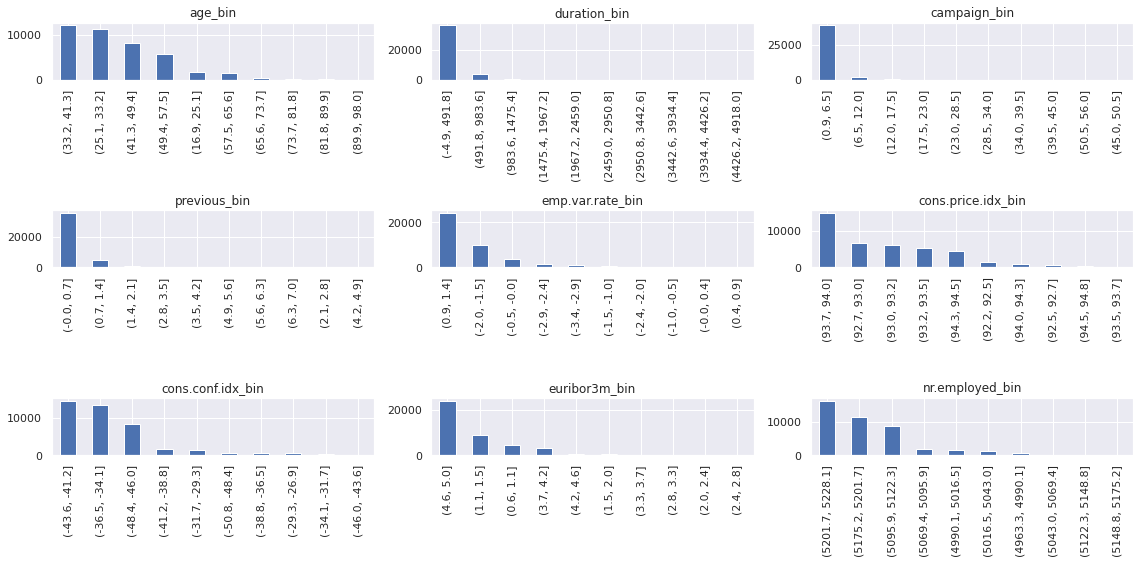

In [236]:
#set a list of numeric variables
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)
#create a copy of the dataframe
df_cut = df.copy()
#set a number of bins
bins = 10
#bin each column and plot it
for i in numeric:
    _, edges = pd.cut(df_cut[i], bins=bins, retbins=True)
    labels = [f'({edges[b]:.1f}, {edges[b+1]:.1f}]' for b in range(bins)]
    df_cut[i +'_bin'] = pd.cut(df_cut[i], bins=bins, labels=labels, ordered=False)
display(df_cut.head(5))

binned = [i for i in df_cut.columns if 'bin' in i]
fig, axs = plt.subplots(nrows=3, ncols=3, figsize = (16,8))
for i, ax, title in zip(binned,axs.reshape(-1), binned):
    df_cut[i].value_counts().plot(kind = 'bar', ax = ax)
    ax.title.set_text(title)
fig.tight_layout()
plt.show()

We can see that in comparison to initial condition, the distributions became smoother.
So, we could consider this method for future purposes.
Now, let's move to the output variable and start to explore it's relation to the other variables in the data set.
We plot a ratio between positive and negative answers (subscribed a term deposit or not) and see that our data is imbalanced. We need to take this fact into account when building the models.

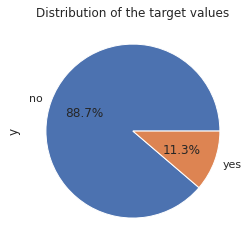

In [290]:
#create a pie plot
df.y.value_counts(normalize = True).plot(kind='pie', y = 'y', autopct='%1.1f%%', title = 'Distribution of the target values');

Now we are going to explore relationships between our output variable and numeric input variables. First, we could visually look if means for y = no and y = yes are different for each numeric feature.

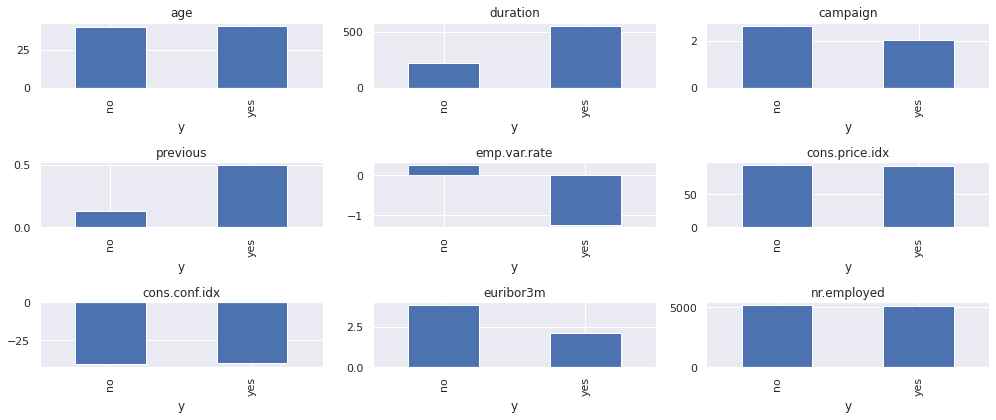

,age,duration,campaign,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
y,,,,,,,,,
no,39.910994,220.868079,2.633385,0.132414,0.248885,93.603798,-40.593232,3.811482,5176.165690
yes,40.912266,553.256090,2.051951,0.492779,-1.233089,93.354577,-39.791119,2.123362,5095.120069


In [121]:
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)
fig, axs = plt.subplots(3,3, figsize = (14,6))
for i, ax, title in zip(numeric,axs.reshape(-1), numeric):
    df.groupby('y')[i].mean().plot(kind = 'bar', ax = ax)
    ax.set_title(title)
    plt.tight_layout()   
plt.show()  
df.groupby('y').mean()

We can see that several numeric features have a visualy significant difference in means. For example, duration of a call for negative answers is much less, customers who answered 'no', were contacted more often (campaign). Vise versa, previously they were contacted less often than customers, who answered 'yes' (previous). Negative answers subgroup has a higher employment variance rate but lower short-term lending rates (eurlibor 3 months). We don't see any significant difference for the rest of the variables.

Another way to find out how the input features are related to the target variable - use statistical tests. For this purpose we will use 2 samples Student t-test. For each numeric feature we will compare samples, where y is equal to 'yes' and 'no' respectively. When conducting the t-test, we assume that samples have equal variances and that data is normally distributed (for big samples it's not a strict assumption). As a rule of thumb, we can assume the populations have equal variances if the ratio of the larger sample variance to the smaller sample variance is less than 4:1. 
Hypothesis:
H0 - positive and negative y samples means are equal
H1 - positive and negative y samples means are not equal

In [249]:
import numpy as np
from scipy import stats
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)

#first let's check the assumptions
#n1 - have equal variances, n2 - have normal distribution
def t_test(feature):
    #calculate samples' variance
    var1 = np.var(df[df.y == 'yes'][feature])
    var2 = np.var(df[df.y == 'no'][feature])
    #conduct a test for normality
    k2, p = stats.normaltest(df[feature])
    print("-Ratio between variances for {} - {:g}. P-value (check for normal dist.) for {} = {:g}".format(feature, round(var1/var2, 2), feature, p))
    if var1/var2 < 4:
        stat, p = stats.ttest_ind(a=df[df.y == 'yes'][feature], b=df[df.y == 'no'][feature], equal_var=True)
    else:
        stat, p = stats.ttest_ind(a=df[df.y == 'yes'][feature], b=df[df.y == 'no'][feature], equal_var=False)
    print("P-value (t-test) for {} - {:g}".format(feature, p))
for i in numeric:
    t_test(i)

-Ratio between variances for age - 1.95. P-value (check for normal dist.) for age = 0
P-value (t-test) for age - 7.00324e-10
-Ratio between variances for duration - 3.75. P-value (check for normal dist.) for duration = 0
P-value (t-test) for duration - 0
-Ratio between variances for campaign - 0.34. P-value (check for normal dist.) for campaign = 0
P-value (t-test) for campaign - 2.04343e-41
-Ratio between variances for previous - 4.42. P-value (check for normal dist.) for previous = 0
P-value (t-test) for previous - 1.68378e-161
-Ratio between variances for emp.var.rate - 1.2. P-value (check for normal dist.) for emp.var.rate = 0
P-value (t-test) for emp.var.rate - 0
-Ratio between variances for cons.price.idx - 1.46. P-value (check for normal dist.) for cons.price.idx = 0
P-value (t-test) for cons.price.idx - 1.62223e-169
-Ratio between variances for cons.conf.idx - 1.95. P-value (check for normal dist.) for cons.conf.idx = 5.147e-204
P-value (t-test) for cons.conf.idx - 9.13218e-29


Obtained results show that almost all features have equal variance except for previous feature. For this feature we pass an argument that variances are not equal. As for check for normality of distributions, all p-values are less than 0.05. That means we need to reject null hypothesis - features are normally distributed. However, since we have a large data set, violation of this assumption is not critical.
Finally, for each numeric features Student t-test shows significant difference for two samples means (subscribed/didn't subscribe a term deposit). Each p-value is less than 0.05 - accepted significance level. We can conclude that there is relationship between the target feature values and the input features values.

Additionally, we decided to conduct ANOVA(analysis of variance) test. Typically, a one-way ANOVA is used when you have three or more categorical, independent groups, but it can be used for just two groups.

In [265]:
from scipy.stats import f_oneway
def anova(feature):
    # Running the one-way anova test between numeric input and target
    # Assumption(H0) is that input and output are NOT correlated
    CategoryGroupLists=df.groupby('y')[feature].apply(list)
    # Performing the ANOVA test
    # We accept the Assumption(H0) only when P-Value <= 0.05
    AnovaResults = f_oneway(*CategoryGroupLists)
    print(f'P-Value for Anova counducted for {feature} is: ', AnovaResults[1])

for i in numeric:
    anova(i)

P-Value for Anova counducted for age is:  7.003243845684908e-10
P-Value for Anova counducted for duration is:  0.0
P-Value for Anova counducted for campaign is:  2.0434309097339834e-41
P-Value for Anova counducted for previous is:  0.0
P-Value for Anova counducted for emp.var.rate is:  0.0
P-Value for Anova counducted for cons.price.idx is:  1.6222328681832695e-169
P-Value for Anova counducted for cons.conf.idx is:  9.132175774550133e-29
P-Value for Anova counducted for euribor3m is:  0.0
P-Value for Anova counducted for nr.employed is:  0.0


ANOVA results are consistent with t-test results. 
Next step is to look at correlations between numeric features themselves.

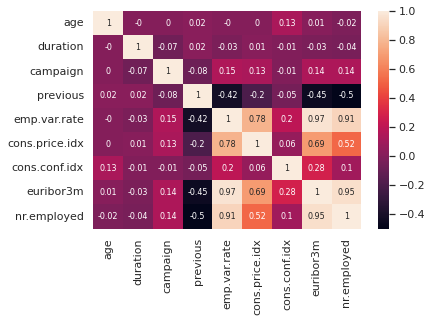

In [238]:
import seaborn as sns
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)

#set font size
sns.set(font_scale=1)

#create correlation matrix
df_corr = df[numeric].corr()
df_corr = df_corr.round(2)

#create correlation heatmap
sns.heatmap(df_corr, annot=True, annot_kws={"size": 8});

We can see that several features related to social and economic context are highly correlated. This fact can cause a problem of multicollinearity in the models. We also can check the features for multicollinearity by calculating VIFs (variance inflation factors).
VIFs do not have any upper limit. The lower the value the better. VIFs between 1 and 5 suggest that the correlation is not severe enough to warrant corrective measures.

In [240]:
import statsmodels.api as sma 
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calculate_vif():
    vif = pd.DataFrame()
    df_num = df[numeric]
    df_vif = sma.add_constant(df_num)
    vif['Variables'] = df_vif.columns
    vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    return vif
calculate_vif()

,Variables,VIF
0,const,528303.388424
1,age,1.018790
2,duration,1.008052
3,campaign,1.038421
4,previous,1.349387
5,emp.var.rate,33.063173
6,cons.price.idx,6.314483
7,cons.conf.idx,2.617565
8,euribor3m,64.331181
9,nr.employed,31.636555


Indeed, several features have extremely high VIF. We should remove some of them to avoid the multicollinearity. Only if we would plan to build a neural network, we can keep highly correlated features. 
Let's look how the picture can change if we remove 2 variables with the highest VIFs.

In [291]:
import statsmodels.api as sma 
from statsmodels.stats.outliers_influence import variance_inflation_factor
numeric = list(df.select_dtypes(include=['int64', 'float64']).columns)
numeric = [i for i in numeric if i != 'euribor3m']
numeric = [i for i in numeric if i != 'emp.var.rate']


def calculate_vif():
    vif = pd.DataFrame()
    df_num = df[numeric]
    df_vif = sma.add_constant(df_num)
    vif['Variables'] = df_vif.columns
    vif['VIF'] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    return vif
calculate_vif()


,Variables,VIF
0,const,528267.886916
1,age,1.018789
2,campaign,1.033691
3,previous,1.349338
4,emp.var.rate,33.063173
5,cons.price.idx,6.313938
6,cons.conf.idx,2.617129
7,euribor3m,64.324341
8,nr.employed,31.620651


Now we can see that there's no VIFs greater than 5, so, the multicollinearity problem could be eliminated.
Let's move to analysis of relation between the target variable and input categorical variables. We can plot number of positive and negative answers for each class in categorical features. Also we will plot a percentage of positive answers and provide tabular data. For more convenient display we'll use a function with an iterator.

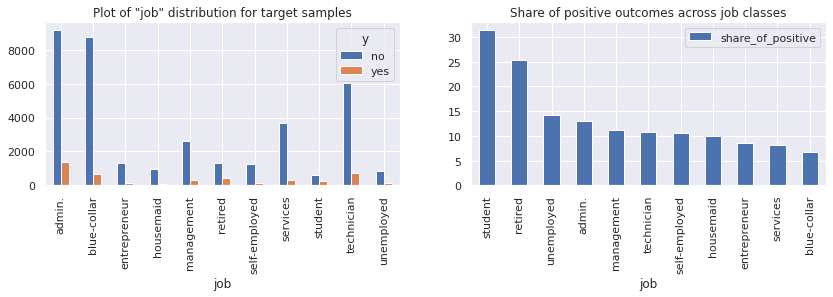

,share_of_positive
job,
student,31.4286
retired,25.3619
unemployed,14.2012
admin.,13.0385
management,11.2666
technician,10.8300
self-employed,10.4856
housemaid,9.8973
entrepreneur,8.5165


In [279]:
#import modules
from IPython.display import display
import matplotlib.pyplot as plt
#create list of categorical features and remove the target feature from it
categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
categories = [i for i in categories if i != 'y']
#create an iterator
categories_iter = iter(categories)
#function code
def next_categ_image1():
    cat = next(categories_iter)
    fig, ax = plt.subplots(1,2, figsize = (14,3))
    pd.crosstab(df[cat], df.y).plot(kind='bar', ax = ax[0], title = f'Plot of "{cat}" distribution for target samples')
    shares = df[df.y == 'yes'].groupby(cat).agg({cat: 'count'})/df.groupby(cat).agg({cat: 'count'})*100
    shares.columns = ['share_of_positive']
    shares.sort_values(by = 'share_of_positive', ascending = False, inplace = True)
    shares.plot(kind = 'bar', ax = ax[1], title = f'Share of positive outcomes across {cat} classes')
    plt.show()   
    display(shares.round(4))
next_categ_image1()

As we can see, ratio between positive and negative answers varies for different job classes. It's quite expectable that for each class share of negative answers is higher. We can see that job feature has no low , top three classes that have the biggest share of y = 'yes' - student, retired, unemployed. Since we can see relation between the target variable and type of job, so, it's needed to keep this feature for a further analysis.

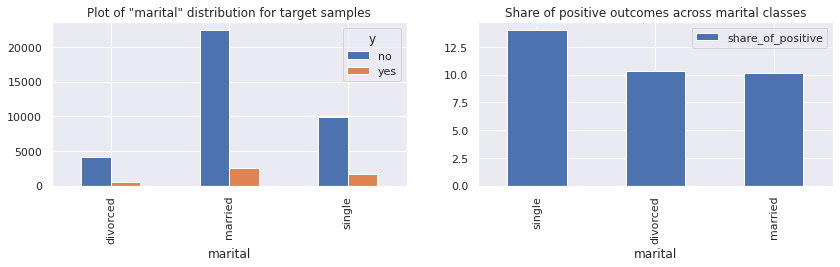

,share_of_positive
marital,
single,14.0093
divorced,10.3359
married,10.1669


In [280]:
next_categ_image1()

Marital status is also connected with y because single customers are more inclined to give a positive answer and subscribe to the term deposit. However there are much less divorced customers than married ones, shares of positive outcomes is almost equal.

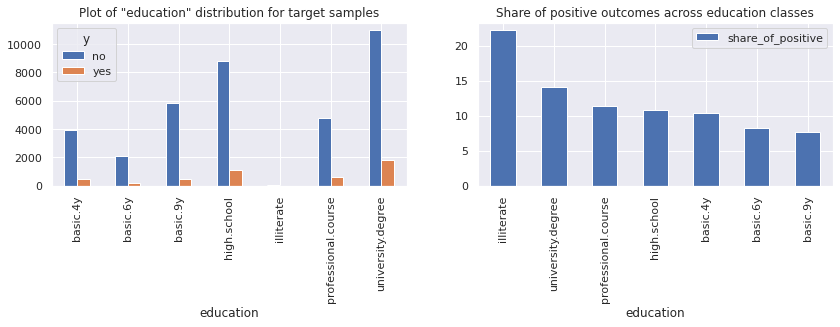

,share_of_positive
education,
illiterate,22.2222
university.degree,14.1359
professional.course,11.3800
high.school,10.8955
basic.4y,10.4138
basic.6y,8.1861
basic.9y,7.6621


In [281]:
next_categ_image1()

Although a share of illiterate customers is extremely small in the entire data set, this class has the highest share of positive outcomes. It's interesting that there's no obvious relation between illiteracy rate and share of positive outcomes because the second place belongs to customers with university degree, the third one - to customers who completed some professional courses. Anyway, this feature might have an impact on the target feature.

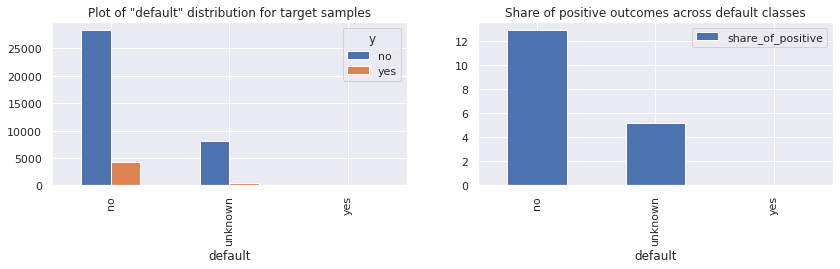

,share_of_positive
default,
no,12.8803
unknown,5.1536
yes,NaN


In [282]:
next_categ_image1()

As for default feature, share of customers who has credit in default is very low in general as expected. Looking at tabular data we can see that there's no customers with credit in default who subscribed the term deposit. We can consider this feature in model building to find out, how the fact that customer doesn't want to reveal information if he has credit in default or not can affect the target variable. However, in general, this feature seems to be not extremely informative because we have only two classes for further analysis and one of them could potentially belong entirely to the second class ('unknown' to 'no'). In this case we could have zero entropy what isn't good for predicting the target.

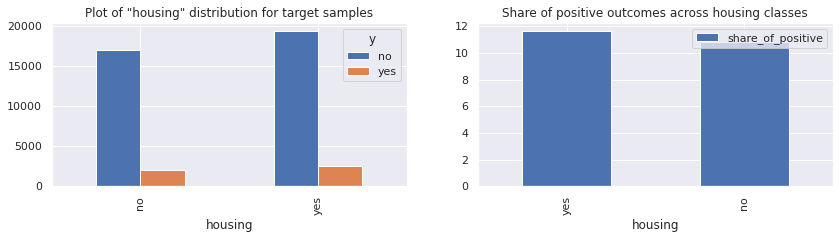

,share_of_positive
housing,
yes,11.6631
no,10.8110


In [283]:
next_categ_image1()

We can see that there's almost no difference for two y classes, either in number of positive and negative outcomes, or in shares of positive outcomes. So, this feature tends to have low predictive power.

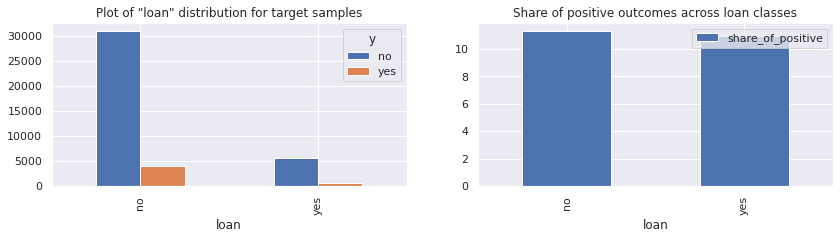

,share_of_positive
loan,
no,11.3268
yes,10.9280


In [284]:
next_categ_image1()

The situation with loan feature is quite similar to housing feature, except that number of positive outcomes in much lower. However, shares of positive outcomes across two classes are almost equal. So, this feature also seems to be not very informative.

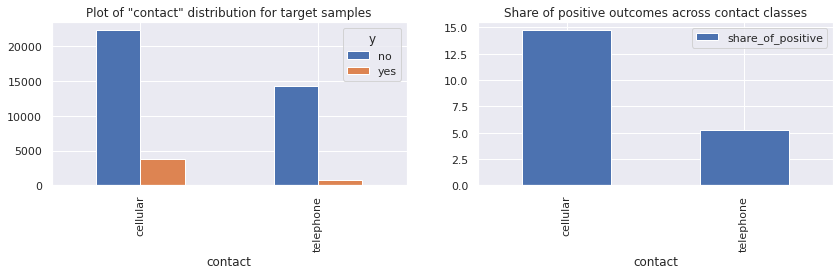

,share_of_positive
contact,
cellular,14.7389
telephone,5.2324


In [285]:
next_categ_image1()

As for type of contact, we can see that relationship exists, so we plan to keep this feature for further analysis.

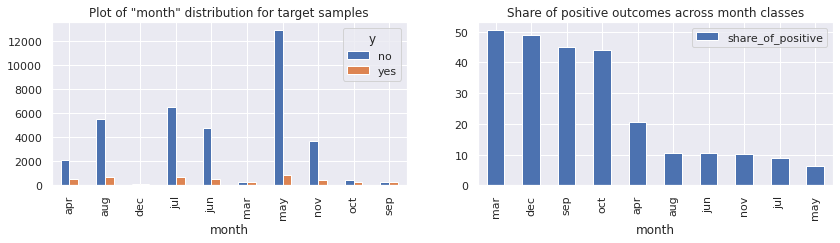

,share_of_positive
month,
mar,50.5495
dec,48.9011
sep,44.9123
oct,43.9331
apr,20.4865
aug,10.6056
jun,10.5115
nov,10.1463
jul,9.0389


In [286]:
next_categ_image1()

Last contact month of year can affect the target, as wee can see. However, the relationship isn't obvious - the first three places are taken by months from different year seasons. So, maybe there's no any regularity here.

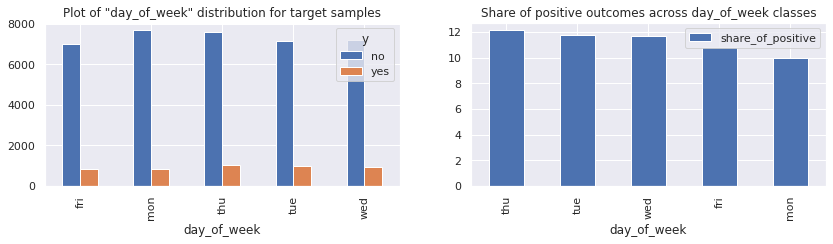

,share_of_positive
day_of_week,
thu,12.1142
tue,11.7858
wed,11.6671
fri,10.8101
mon,9.9507


In [287]:
next_categ_image1()

As for day of the week, we cannot see any strong relationship. On Mondays and Fridays share of positive outcomes is a little bit less. Maybe due to this slight difference we shouldn't exclude this feature from the further analysis and check it's impact on the target.

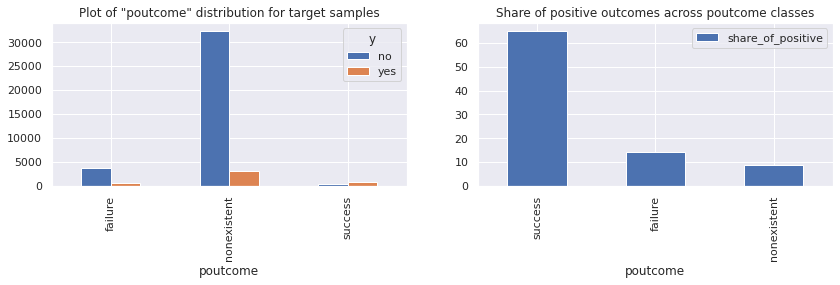

,share_of_positive
poutcome,
success,65.1129
failure,14.2286
nonexistent,8.8324


In [288]:
next_categ_image1()

Outcome of the previous marketing campaign can influence the outcome of the current marketing campaign. We should keep this feature.

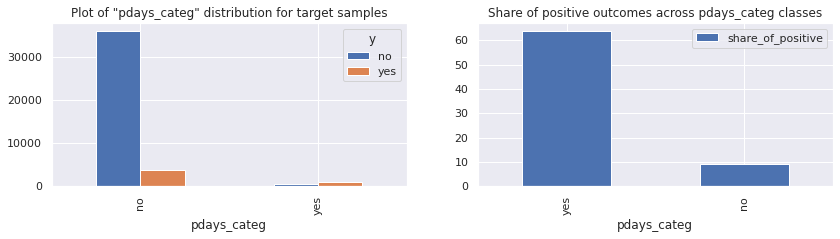

,share_of_positive
pdays_categ,
yes,63.8284
no,9.2585


In [289]:
next_categ_image1()

Finally, the fact that the client was contacted earlier also affects the target. This created feature is quite close to the previous one in meaning, that's why we should try to build the model with this feature and without it to see its personal impact.

To support our assumptions, we can use a Chi-square test for categorical features.
Hypothesis:
H0: two categorical variables being compared are independent of each other.
H1: two categorical variables being compared are dependent of each other.
Also we could use SelectKBest method to select the categorical features which have the highest level of dependence with the target but we'd like to have a look at all the features.

In [264]:
#import modules
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import preprocessing
#copy the dataframe
df_chi2 = df.copy()

# Create features list
categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
categories_ed = [i for i in categories if i != 'education']
categories_y = [i for i in categories if i != 'y']
#encode all the features
le = preprocessing.LabelEncoder()
for i in categories_ed:
    df_chi2[i] = le.fit_transform(df_chi2[i])
list_of_education = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
#encode education as an ordinal feature
df_chi2.education = df_chi2.education.replace(to_replace = list_of_education, value = list(range(len(list_of_education))))

#define X and Y
X = df_chi2.drop('y', axis=1)[categories_y]
Y = df_chi2.y
# Select features with highest chi-squared statistics
chi2_selector = SelectKBest(chi2, k=10)
chi2_selector.fit(X, Y)

# Look at scores returned from the selector for each feature
chi2_scores = pd.DataFrame(list(zip(X[categories_y].columns, chi2_selector.scores_, chi2_selector.pvalues_)), columns=['ftr', 'score', 'pval'])
display(round(chi2_scores.sort_values(by = 'pval'),4).reset_index(drop = True))

,ftr,score,pval
0,pdays_categ,4186.8682,0.0000
1,contact,547.7785,0.0000
2,default,321.8911,0.0000
3,poutcome,98.2633,0.0000
4,job,92.9062,0.0000
5,education,86.2995,0.0000
6,marital,27.0094,0.0000
7,day_of_week,10.2336,0.0014
8,housing,3.4657,0.0627
9,month,1.9178,0.1661


As a result, we can see that all the features except housing, month and loan have p-values less than 0.05. This means that there's dependence between these features and the target. As for three features with p-value more than 0.05, their usefulness for analysis is being questioned. We could compare predictive power of models with and without them.

Additionally to the main analysis of relationships between the features and the target we also can explore relationships between the categorical features using label encoding and visualization. We will explore just several features not to be repetitive.

{'contact': {'cellular': 0, 'telephone': 1},
'day_of_week': {'fri': 0, 'mon': 1, 'thu': 2, 'tue': 3, 'wed': 4},
'default': {'no': 0, 'unknown': 1, 'yes': 2},
'education': {'basic.4y': 1,
             'basic.6y': 2,
             'basic.9y': 3,
             'high.school': 4,
             'illiterate': 0,
             'professional.course': 5,
             'university.degree': 6},
'housing': {'no': 0, 'yes': 1},
'job': {'admin.': 0,
       'blue-collar': 1,
       'entrepreneur': 2,
       'housemaid': 3,
       'management': 4,
       'retired': 5,
       'self-employed': 6,
       'services': 7,
       'student': 8,
       'technician': 9,
       'unemployed': 10},
'loan': {'no': 0, 'yes': 1},
'marital': {'divorced': 0, 'married': 1, 'single': 2},
'month': {'apr': 0,
         'aug': 1,
         'dec': 2,
         'jul': 3,
         'jun': 4,
         'mar': 5,
         'may': 6,
         'nov': 7,
         'oct': 8,
         'sep': 9},
'pdays_categ': {'no': 0, 'yes': 1},
'poutcome': {'f

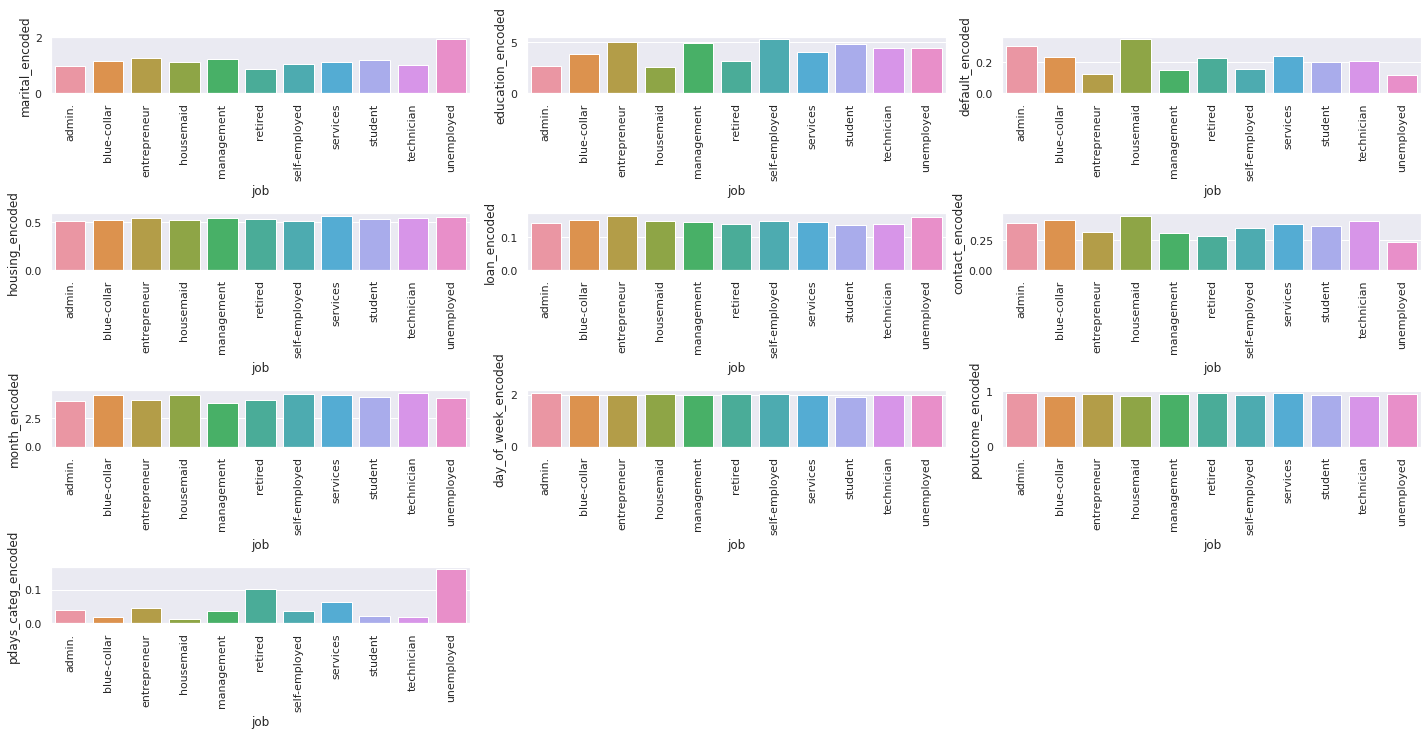

In [267]:
#import modules
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn import preprocessing
import pprint
#define all the necessary variables
pp = pprint.PrettyPrinter(indent=0)
categories = list(df.select_dtypes(exclude=['int64', 'float64']).columns)
categories_ed = [i for i in categories if i not in ['y', 'education']]
categories = [i for i in categories if i not in ['y']]
categories_iter = iter(categories)
df_cat = df.copy()

#define a function that plots categorical features relations
#also display a dictionary with classes names decoding.
def next_categ_image2():
    le = preprocessing.LabelEncoder()
    labels_dict = {} 
    for i in categories_ed:
        le.fit(df[i])
        df_cat[i+'_encoded'] = le.transform(df[i])
        labels = dict(zip(le.classes_, le.transform(le.classes_)))
        labels_dict[i] = labels
    list_of_education = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']
    #encode education as an ordinal feature
    df_cat['education_encoded'] = df_cat.education.replace(to_replace = list_of_education, value = list(range(len(list_of_education))))
    labels_dict['education'] = {k:v for k,v in zip(list_of_education, list(range(len(list_of_education))))}
    cat = next(categories_iter)
    fig, axs = plt.subplots(4,3, figsize = (20,10))
    fig.delaxes(axs[3,1])
    fig.delaxes(axs[3,2])
    other_categ = [c+'_encoded' for c in categories if c != cat]
    if cat == 'job':   
        pp.pprint(labels_dict)
    for y, ax in zip(other_categ,axs.reshape(-1)):
        ax = sns.barplot(x=cat, y=y, data=df_cat, ci=None, ax = ax)
        ax.set_xticklabels(labels_dict[cat.replace('_encoded', '')].keys(), rotation='vertical')
        plt.tight_layout()

next_categ_image2()

- more unemployed tend to be singles
- entrepreneurs, management and self-employed have a higher education level
- housemaids are more prone to have a credit in default
- enterpreneurs and unemployed have a little higher probability to have a loan
- unemployed and retired were contacted before more often

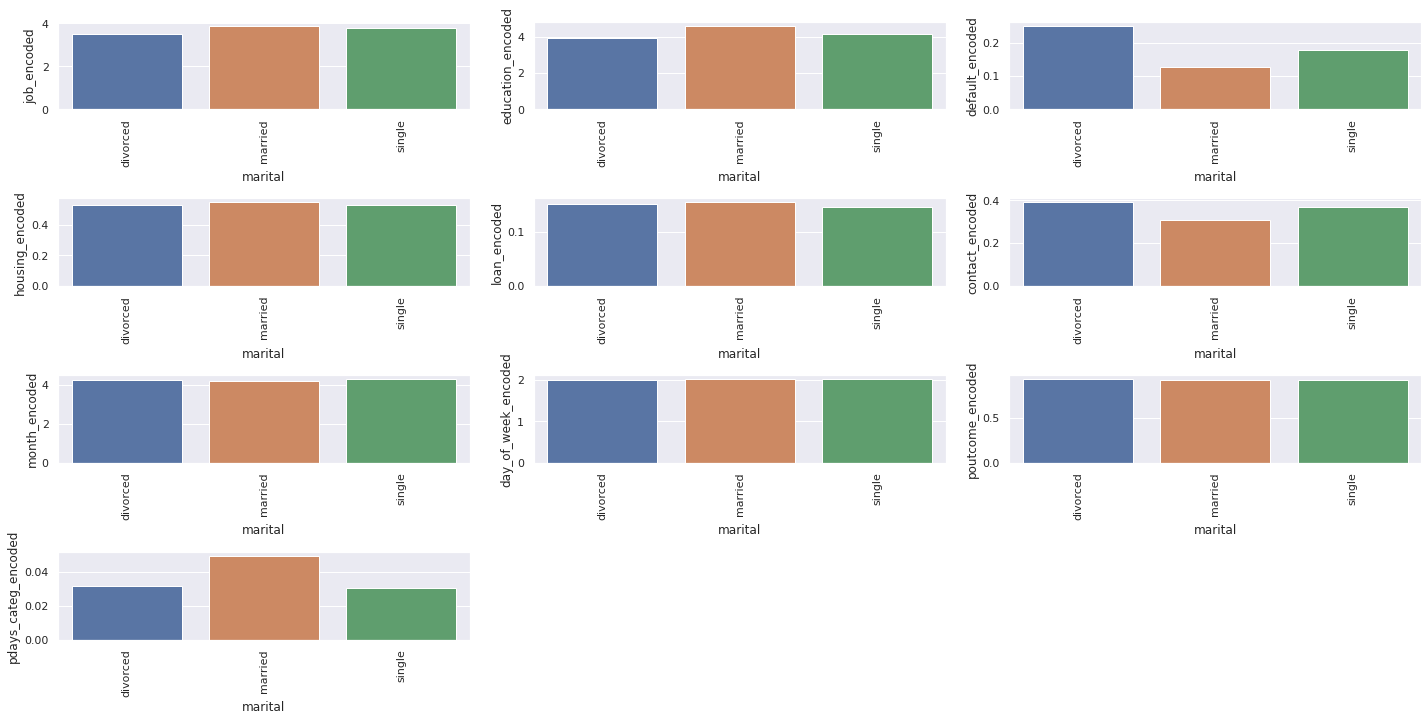

In [268]:
next_categ_image2()

- married in average have a little bit higher education level
- married are less prone to have a credit in default
- married are contacted by cellular more often
- married were previously contacted more often

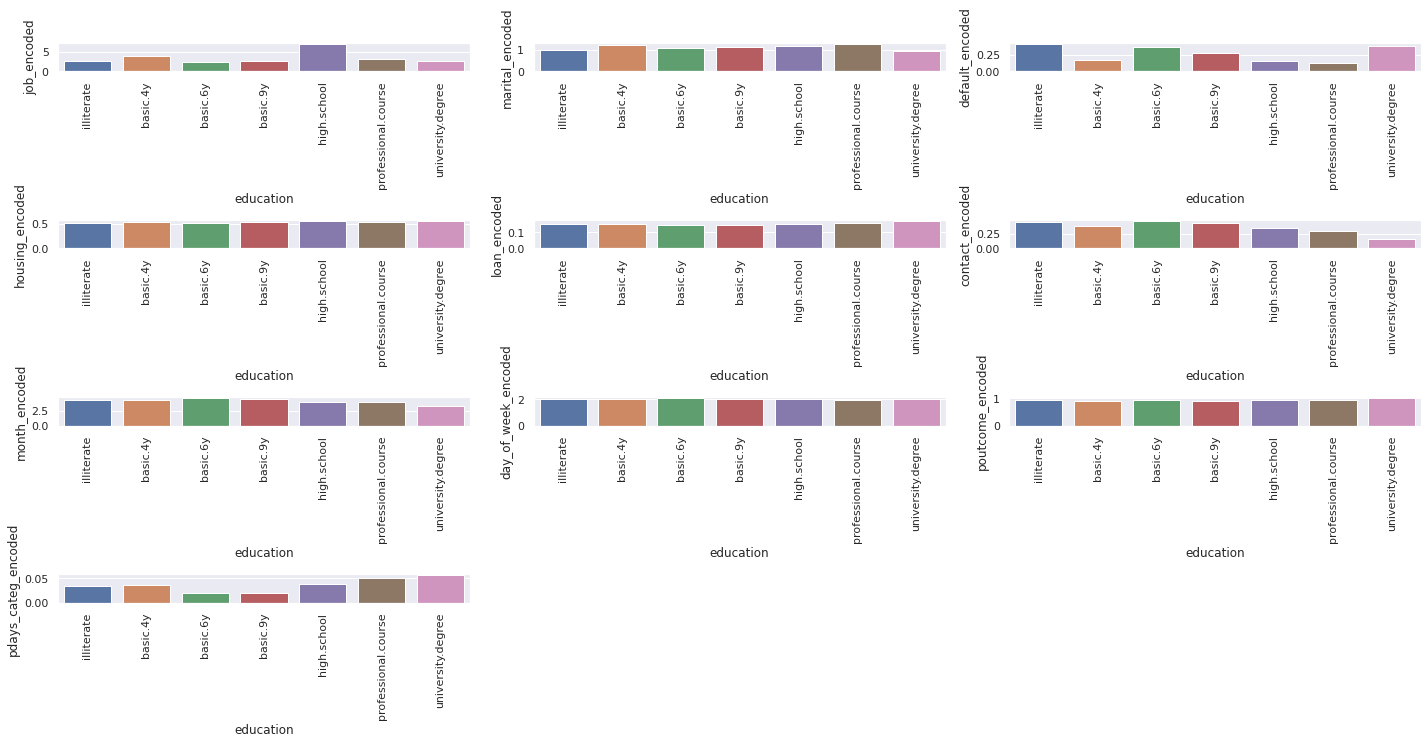

In [269]:
next_categ_image2()

- illiterate, basic 6y and university degree are more prone to have a credit in default
- customers with university degree are contacted by cellular more often 
- customers with university degree and professional course were contacted before more often 

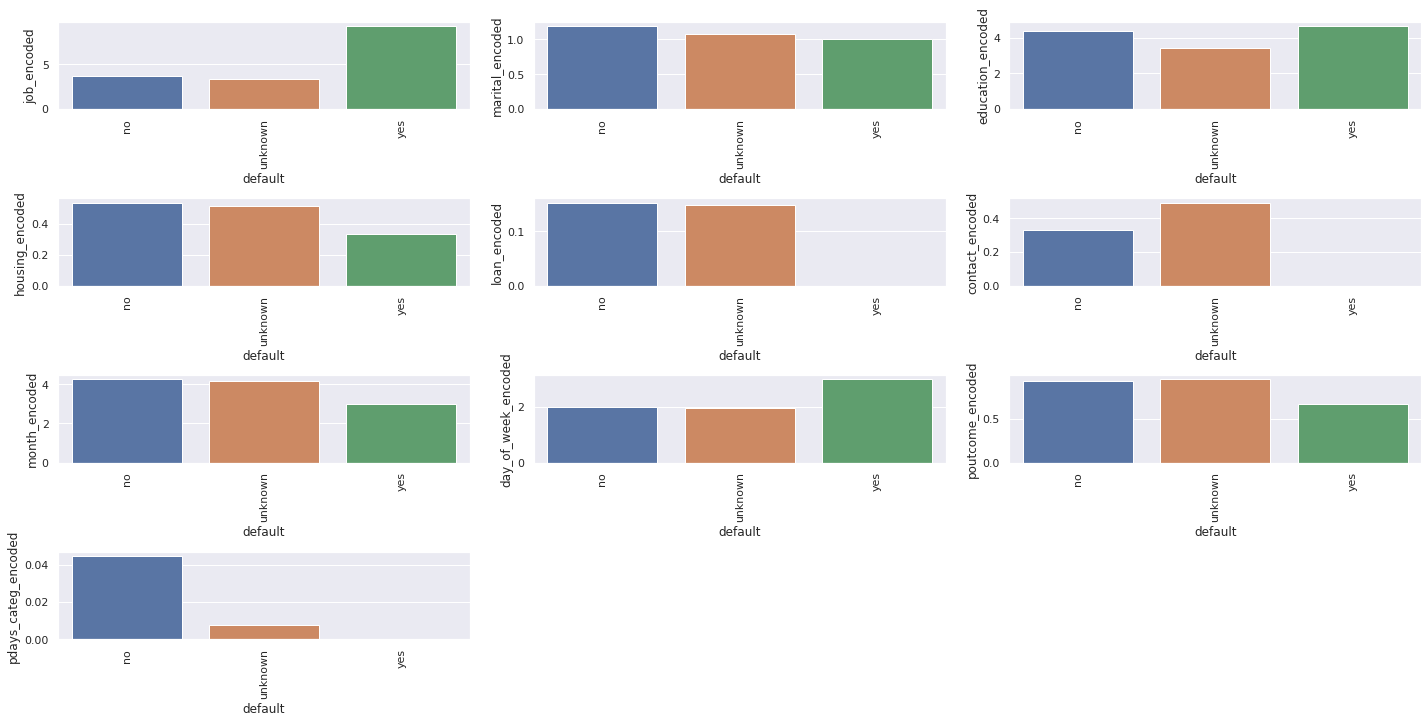

In [270]:
next_categ_image2()

- unemployed have a higher probability to have a credit in default
- people with a credit in default are less prone to have a housing, they don't have loans and weren't contacted neither by cellular, nor by telephone
- people with a credit in default had a successful outcome in a previous marketing campaign less often
- people with a credit in default weren't contacted before

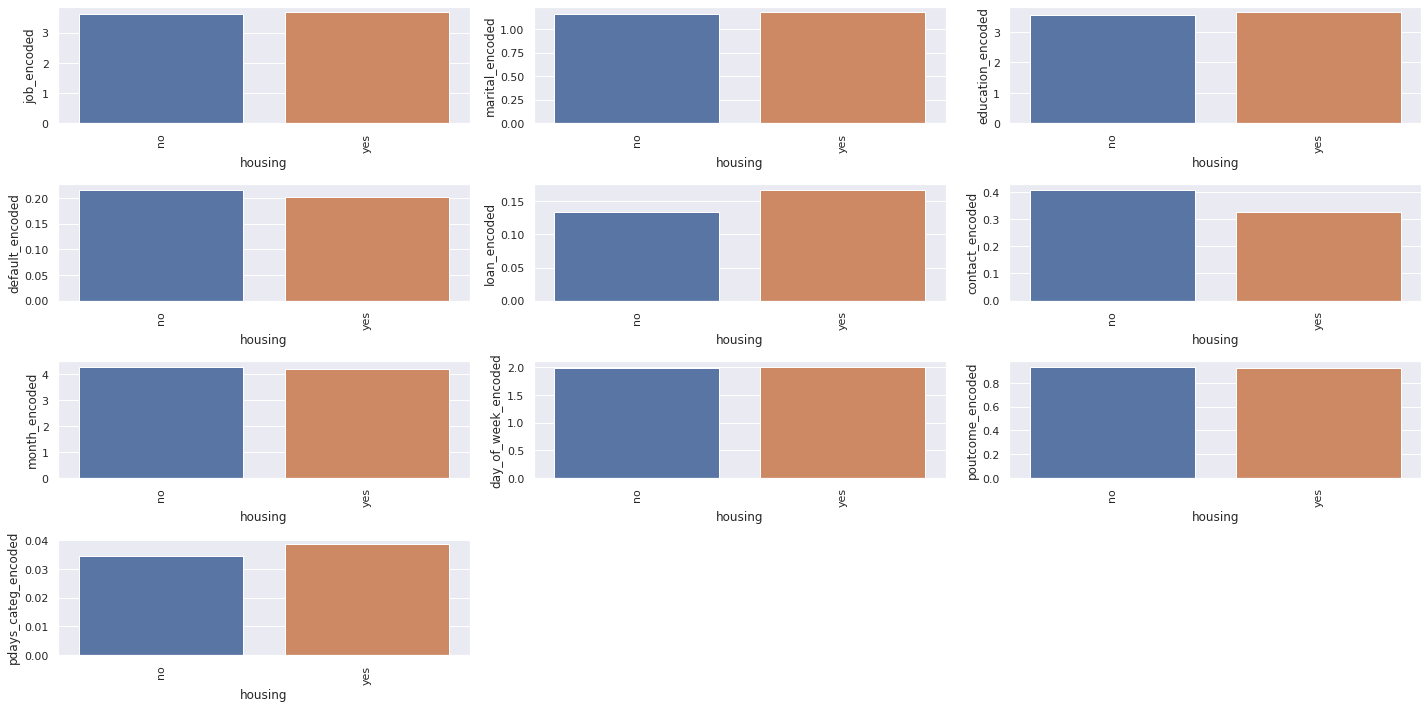

In [39]:
next_categ_image2()

- people with a housing loan were contacted by cellular more often
- people with a housing loan have a personal loan with a higher probability
- people with a housing loan were contacted before more often

We skip several features with quite weak relations or with relations that were already mentioned.

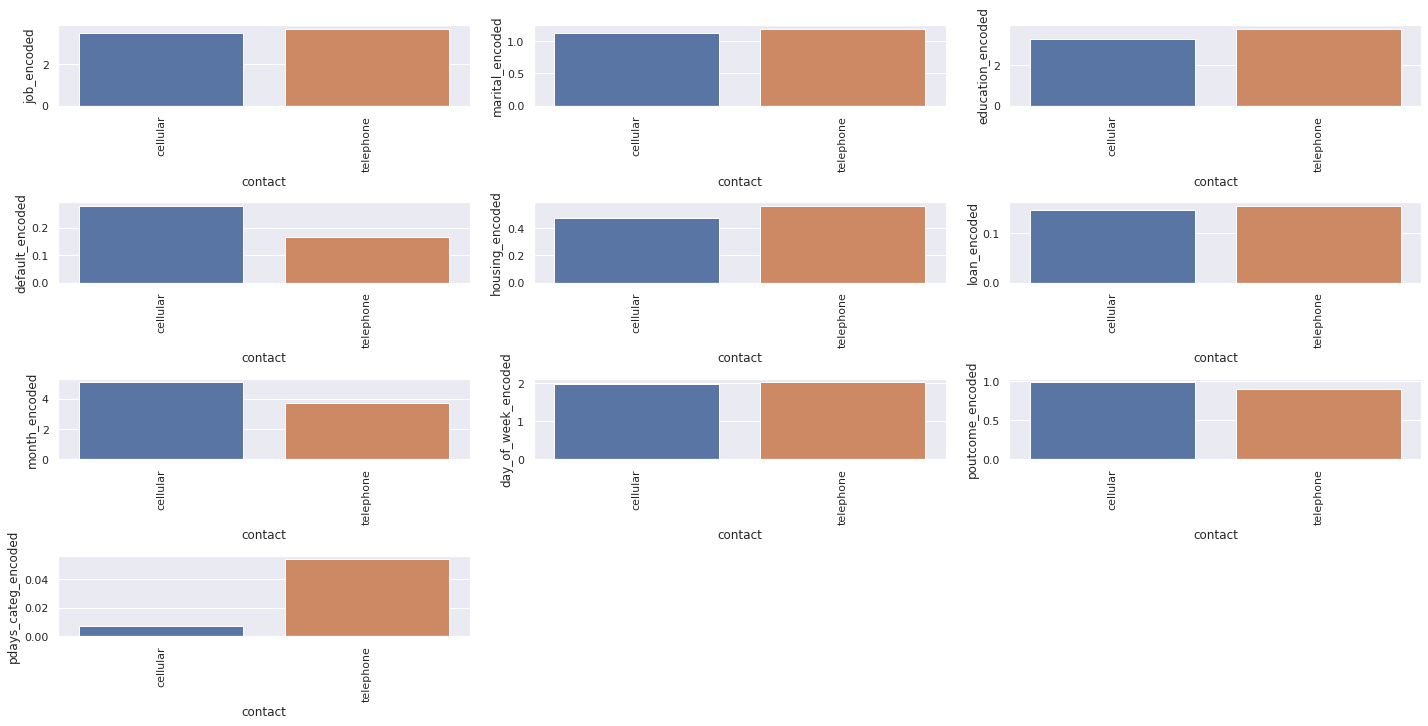

In [41]:
next_categ_image2()

- people with a higher education level are contacted by telephone more often
- people who has a credit in default are contacted by cellular more often
- people who was contacted by cellular in average were contacted before less often

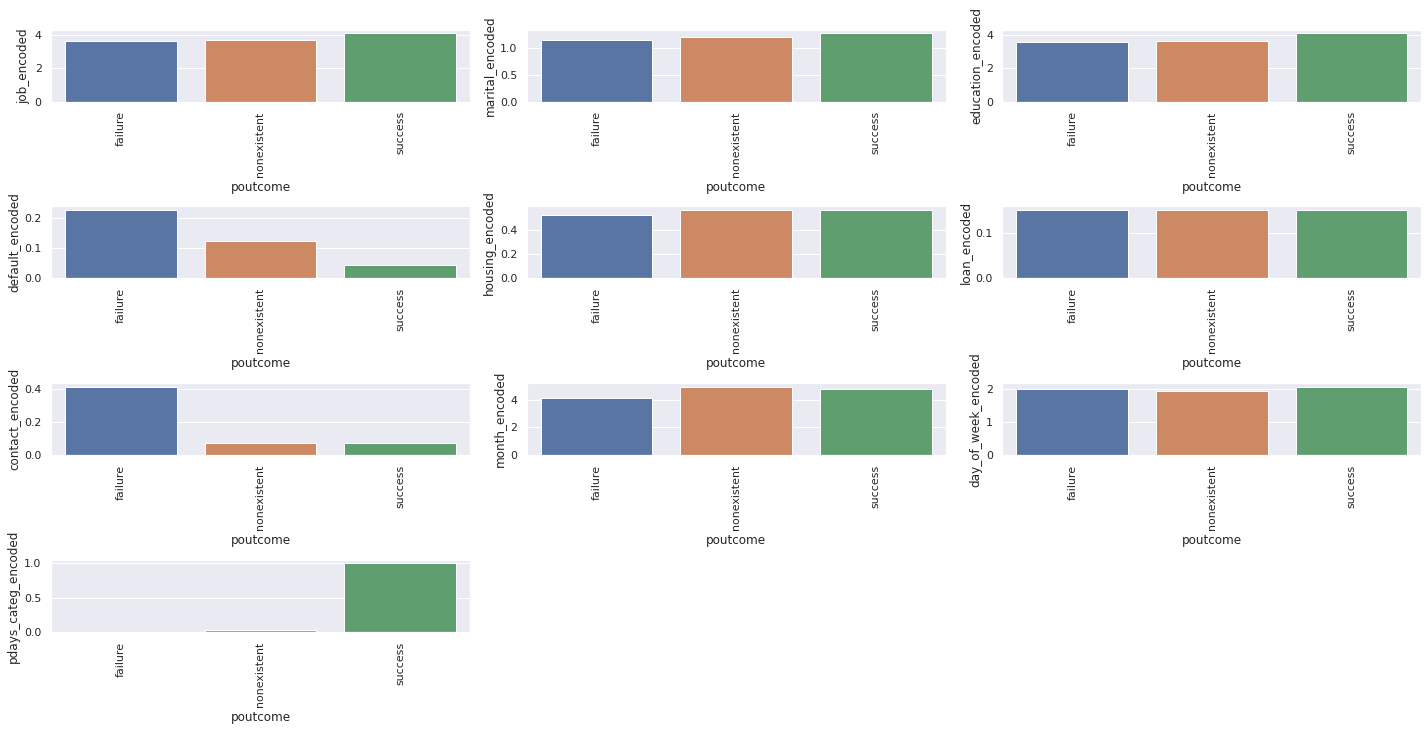

In [44]:
next_categ_image2()

- singles had a successful outcome of the previous campaign more often
- people with a higher education level had a successful outcome of the previous campaign more often
- people with a credit in default had an unsuccessful outcome of the previous campaign more often
- people contacted by telephone had an unsuccessful outcome of the previous campaign more often
- people with a successful campaign outcome were contacted more often

<h4>Final recommendations</h4>

Data cleansing and transformation: 
- Drop duplicates.
- Transform pdays feature to categorical.
- Fill unknown values using KNN approach.
- Keep outliers (but also consider a z-score approach as a benchmark).
- Keep skewed distribution (but also consider a binning option as a benchmark).

Features selection:
- Remove numerical features – euribor3m and emp.var.rate to avoid a multicollinearity problem. In case of building a neural network we can try to keep them.
- Consider models with and without duration feature, as stated in he task.
- Categorical features that might be excluded from the analysis – housing, month, loan, day of week, default. - Need to explore their impact on the target by building models with and without these features.

Business part:

At the first glance we can conclude, that customers tend to subscribe to a term deposit if:
- They are students, retired or unemployment
- They are single
- They either illiterate or have university degree/professional courses
- They have no a credit in default
- They rather have a housing loan
- They rather don’t have a personal loan
- They were contacted by a cellular
- They rater were contacted in March, December, September or October
- They participated in a previous marketing campaign and subscribed

<h4>References:</h4>

1. https://www.analyticsvidhya.com/blog/2021/02/multicollinearity-problem-detection-and-solution/
2. https://stats.stackexchange.com/questions/9573/t-test-for-non-normal-when-n50
3. https://machinelearningmastery.com/a-gentle-introduction-to-normality-tests-in-python/
4. https://services.google.com/fh/files/misc/exploratory_data_analysis_for_feature_selection_in_machine_learning.pdf
5. https://www.technologynetworks.com/informatics/articles/one-way-vs-two-way-anova-definition-differences-assumptions-and-hypotheses-306553
6. https://www.statology.org/two-sample-t-test-python/
7. https://www.technologynetworks.com/informatics/articles/one-way-vs-two-way-anova-definition-differences-assumptions-and-hypotheses-306553